# Problem Set 4: Neural Networks

**Release Date:** 21 October 2024

**Due Date:** 2 November 2024

## Overview

In the real world, while fundamentals are welcomed and appreciated, implementing algorithms from scratch is time consuming, especially when it comes to Deep Learning (DL) models like neural networks with many layers. Backpropagating manually or by hand is often tedious and erroneous. Which is why, it is absolutely critical to learn **at least one** Machine Learning library, either to get jobs or build projects in this field. As such, in *Problem Set 4*, we will introduce you to **PyTorch**.

![PyTorch](images/logo.png)

`PyTorch` is one of the most widely-used DL library. It offers a very Pythonic API to build layers and compose them together. In fact, data processing is also made easy using the multitude of tools and wrappers that are at your disposal. Of course, there are other popular libraries such as `TensorFlow`, but they require you to understand "computation graphs", which we feel makes it less accessible for beginners. Hence, we decided to use PyTorch for CS2109S. 

In *Problem Set 4*, we will attempt to help you learn the `PyTorch` API by having you build a simple deep neural network and training it locally on your system via backpropagation and stochastic gradient descent. You will also learn how to build data processing pipelines to prepare your data before ingestion into your model(s). Subsequently, you will be building a __Convolutional Neural Network__ (CNN/ConvNet) and training it on two datasets, *MNIST* and *CIFAR-10*. You'll also learn how to build __data augmentation pipelines__ to enhance your dataset.

In [1]:
# RUN THIS CELL FIRST
import math
from collections import OrderedDict

import matplotlib.pyplot as plt
import torch  
import torch.nn as nn # PyTorch's module wrapper 
import torch.nn.functional as F #functional generally used for stateless operations 
from torchvision import datasets, transforms #for computer vision and image processing tasks

import numpy as np
from numpy import allclose, isclose

from collections.abc import Callable

device = "cuda" if torch.cuda.is_available() else "cpu" #
print(device)

cuda


# 1 Tensors in PyTorch

### Concept 1.1 - What are Tensors?

In your linear algebra class, you have learnt about vectors. In essence, they are 1-dimensional (1D) serial arrays (like `[1, 2, 3, 4, 23, 18]`) containing a column (or row) of information. You have also learned about matrices – they are "rectangles" (i.e., 2D arrays) that also capture elements.

**Tensors** generalise the concept of matrices: they are $n$-dimensional arrays that contain or represent information. In *PyTorch*, everything is defined as a `tensor`. It's analogous to `np.array(...)` from *NumPy*. A `tensor` object in *PyTorch* looks like this:

![PyTorch](images/tensors.png)


---
The following are some mappings of useful functions between Numpy and Pytorch, in fact, they are so similar that there is a function `torch.from_numpy(ndarray)` which transforms a NumPy array into a PyTorch tensor! The main difference in the functions in the table below is that NumPy and PyTorch functions takes as input and gives as output either `numpy` array or `torch` tensors, respectively. PyTorch tensors also have an additional functionality for GPU acceleration. Refer to this [website](https://pytorch-for-numpy-users.wkentaro.com/) for more information.

![PyTorch](images/numpy_pytorch_diff.png)

### Demo 1.1 - Tensor functions

Notice that tensors have a `.grad` attribute. This is used for automatic gradient computation.  
To create tensors, you can use the `torch.tensor(...)` constructor:  

A 0-dimensional tensor: `torch.tensor(5.0)`  
A 1-dimensional tensor: `torch.tensor([1.0, 2.0, 3.0])`  
A 2-dimensional tensor: `torch.tensor([[.4, .3], [.1, .2]])`  

If automatic gradient computation is required, then the equivalent constructors will be:  
`torch.tensor(5.0, requires_grad=True)`  
`torch.tensor([1.0, 2.0, 3.0], requires_grad=True)`  
`torch.tensor([[.4, .3], [.1, .2]], requires_grad=True)`  

We can call `detach()` on these tensors to stop them from being traced for gradient computation, returning us the tensors without `requires_grad=True`.

We can call `item()` on our tensors to return the value of our tensor as a standard Python number:

`>>> torch.tensor([1.0]).item()`

`1.0`

The following code block shows how we can make use of all these functions introduced.

In [2]:
# Create a tensor with requires_grad set to True
x = torch.tensor([2.0], requires_grad=True)

# Compute the gradient of a simple expression using backward
y = x**2 + 2 * x
y.backward()

# Print the derivative value of y i.e dy/dx = 2x + 2 = 6.0.
print("Gradient of y with respect to x:", x.grad)

# Detach the gradient of x
x = x.detach()

# Print the gradient of x after detachment
print("Gradient of x after detachment:", x.grad)

# Extract the scalar value of a tensor as a Python number
x_value = x.item()
print("Value of x as a Python number:", x_value)

Gradient of y with respect to x: tensor([6.])
Gradient of x after detachment: None
Value of x as a Python number: 2.0


### Demo 1.2 - Working with Tensors

Here, we use `torch.linspace` to create a `torch.tensor`. In PyTorch (and Machine Learning in general) tensors form the basis of all operations.

We then make use of the built-in *PyTorch* function `torch.sin` to create the corresponding y-values of a sine function, and plot the points using *Matplotlib*.

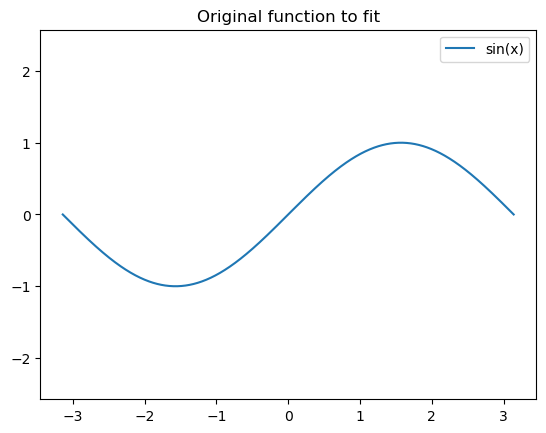

In [3]:
# This is a demonstration: You just need to run this cell without editing.

x = torch.linspace(-math.pi, math.pi, 1000) # Task 1.1: What is torch.linspace?
y_true = torch.sin(x)

plt.plot(x, y_true, linestyle='solid', label='sin(x)')
plt.axis('equal')
plt.title('Original function to fit')
plt.legend()
plt.show()

In [4]:
# Run this cell to explore what the FIRST 10 VALUES of x has been assigned to.
# By default, each cell will always print the output of the last expression in the cell
# You can explore what x is by modifying the expression e.g. x.max(), x.shape
x[0]
x.shape

# x.shape
# x[:10]

torch.Size([1000])

### Task 1.1 - What is `torch.linspace`?

From the example above, answer the following questions:

1. What does `x = torch.linspace(-math.pi, math.pi, 1000)` do?  
2. How many values are stored in `x`?  
3. What are the minimum and maximum values in `x`?  

### Demo 1.3 - Using Tensors for linear regression

For this example, we fit a **degree 3 polynomial** to the sine function, using a learning rate of `1e-6` and `5000` iterations.

iter	loss	
----	----
1000	0.4506033957004547
2000	0.4224050045013428
3000	0.40602096915245056
4000	0.396359920501709
5000	0.39052513241767883


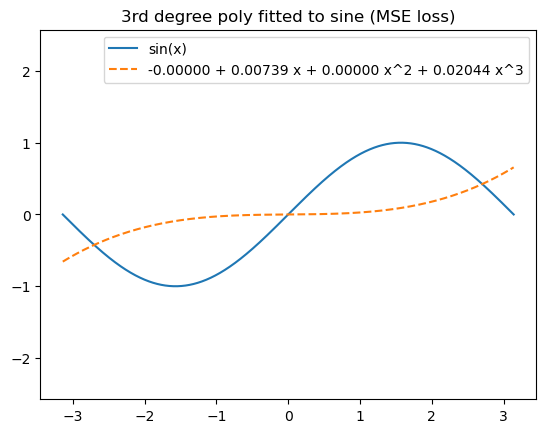

In [5]:
# This is a demonstration: You just need to run this cell without editing.

# Set learning rate
learning_rate = 1e-6

# Initialize weights to 0
a = torch.tensor(0.)
b = torch.tensor(0.)
c = torch.tensor(0.)
d = torch.tensor(0.)

print('iter', 'loss', '\n----', '----', sep='\t')
for t in range(1, 5001): # 5000 iterations
    # Forward pass: compute predicted y
    y_pred = a + b * x + c * x**2 + d * x**3

    # Compute MSE loss
    loss = torch.mean(torch.square(y_pred - y_true))
    if t % 1000 == 0:
        print(t, loss.item(), sep='\t')

    # Backpropagation
    grad_y_pred = 2.0 * (y_pred - y_true) / y_pred.shape[0]
    
    # Compute gradients of a, b, c, d with respect to loss
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # Update weights using gradient descent
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d

# print fitted polynomial
equation = f'{a:.5f} + {b:.5f} x + {c:.5f} x^2 + {d:.5f} x^3'

y_pred = a + b * x + c * x**2 + d * x**3
plt.plot(x, y_true, linestyle='solid', label='sin(x)')
plt.plot(x, y_pred, linestyle='dashed', label=f'{equation}')
plt.axis('equal')
plt.title('3rd degree poly fitted to sine (MSE loss)')
plt.legend()
plt.show()

### Demo 1.4 - Using autograd to automatically compute gradients

In the previous example, we explicitly computed the gradient for Mean Squared Error (MSE):  
`grad_y_pred = 2.0 * (y_pred - y_true) / y_pred.shape[0]`

In the next example, we will use PyTorch's autograd functionality to help us compute the gradient for **Mean Absolute Error (MAE)**.  
In order to compute the gradients, we will use the `.backward()` method of *PyTorch* tensors.

Once again, we fit a **degree 3 polynomial** to the sine function, using a learning rate of `1e-6` and `5000` iterations.  
This time, we will use MAE instead of MSE.

iter	loss	
----	----
1000	0.5974264740943909
2000	0.5801820755004883
3000	0.5707745552062988
4000	0.565079927444458
5000	0.5613779425621033


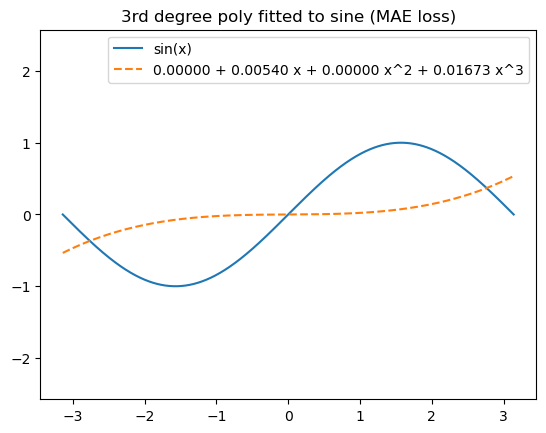

In [6]:
# This is a demonstration: You just need to run this cell without editing.

# Set learning rate
learning_rate = 1e-6

# Initialize weights to 0
a = torch.tensor(0., requires_grad=True)
b = torch.tensor(0., requires_grad=True)
c = torch.tensor(0., requires_grad=True)
d = torch.tensor(0., requires_grad=True)

print('iter', 'loss', '\n----', '----', sep='\t')
for t in range(1, 5001):
    # Forward pass: compute predicted y
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute MAE loss
    loss = torch.mean(torch.abs(y_pred - y_true))
    if t % 1000 == 0:
        print(t, loss.item(), sep='\t')

    # Automatically compute gradients
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad
        a.grad.zero_() # reset gradients !important
        b.grad.zero_() # reset gradients !important
        c.grad.zero_() # reset gradients !important
        d.grad.zero_() # reset gradients !important
        # What happens if you don't reset the gradients?

# print fitted polynomial
equation = f'{a:.5f} + {b:.5f} x + {c:.5f} x^2 + {d:.5f} x^3'

y_pred = a + b * x + c * x ** 2 + d * x ** 3
plt.plot(x, y_true, linestyle='solid', label='sin(x)')
plt.plot(x, y_pred.detach().numpy(), linestyle='dashed', label=f'{equation}')
plt.axis('equal')
plt.title('3rd degree poly fitted to sine (MAE loss)')
plt.legend()
plt.show()

### Task 1.2 - Polyfit model

We have demonstrated how to fit a degree-3 polynomial to a set of `x` and `y` points (following the sine curve), using two different types of loss functions (MSE and MAE).  

Now, your task is to write a function `polyfit` that takes in some arbitrary set of points. You are only allowed to use **ONE** loop for the backpropagation and weights update. You are **NOT** allowed to use a loop to raise the features to their respective powers.
1. `x`, corresponding x-values,  
2. `y`, corresponding true y-values,  
3. `loss_fn` to compute the loss, given the true `y` and predicted `y`,  
4. `n` representing the $n$-degree polynomial, and 
5. `lr` learning rate, and  
6. `n_iter` for the number of times to iterate.  

Return the 1D tensor containing the coefficients of the $n$-degree polynomial , after fitting the model.  
The coefficients should be arranged in ascending powers of $x$.

For example,
```
>>> y = torch.sin(x)
>>> mse = lambda y_true, y_pred: torch.mean(torch.square(y_pred - y_true))
>>> mae = lambda y_true, y_pred: torch.mean(torch.abs(y_pred - y_true))

>>> polyfit(x, y, mse, 3, 1e-3, 5000)
tensor([-4.2270e-09,  8.5167e-01,  1.2131e-08, -9.2587e-02], requires_grad=True))

>>> polyfit(x, y, mae, 3, 1e-3, 5000)
tensor([-9.6776e-07,  8.7905e-01, -2.4784e-06, -9.8377e-02], requires_grad=True))
```

*Note: For this regression problem, initialize your weights to 0.0.*

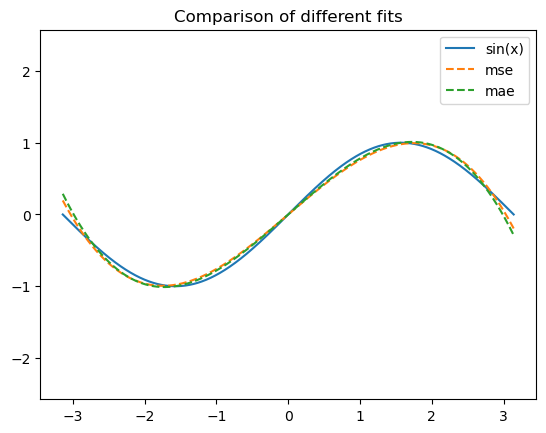

In [7]:
import time
def polyfit(x: torch.Tensor, y: torch.Tensor, loss_fn: Callable, n: int, lr: float, n_iter: int):
    """
    Parameters
    ----------
        x : A tensor of shape (1, n)
        y : A tensor of shape (1, n)
        loss_fn : Function to measure loss
        n : The nth-degree polynomial
        lr : Learning rate
        n_iter : The number of iterations of gradient descent
        
    Returns
    -------
        Near-optimal coefficients of the nth-degree polynomial as a tensor of shape (1, n+1) after `n_iter` epochs.
    """
    """ YOUR CODE HERE """
    x = x.unsqueeze(1) # set shape to (n, 1)
    w = torch.zeros(n + 1, requires_grad=True) # weights = 0, no need reshape because of broadcasting
    d = torch.arange(0,n+1) # degree of polynomial x, 0 for constant
    for _ in range(n_iter):
        #forwards pass
        y_pred = (x**d) @ w
        
        #compute loss 
        loss = loss_fn(y, y_pred)
        
        #backpropagation
        loss.backward()
        #update weights
        with torch.no_grad():
            w -= lr * w.grad
            w.grad.zero_()
    return w
    raise NotImplementedError
    """ YOUR CODE END HERE """

x = torch.linspace(-math.pi, math.pi, 1000)

# Original true values
y = torch.sin(x)
plt.plot(x, y, linestyle='solid', label='sin(x)')

# MSE
mse = lambda y_true, y_pred: torch.mean(torch.square(y_pred - y_true))
a, b, c, d = polyfit(x, y, mse, 3, 1e-3, 5000)
y_pred_mse = a + b * x + c * x ** 2 + d * x ** 3
plt.plot(x, y_pred_mse.detach().numpy(), linestyle='dashed', label=f'mse')

# MAE
mae = lambda y_true, y_pred: torch.mean(torch.abs(y_pred - y_true))
a, b, c, d = polyfit(x, y, mae, 3, 1e-3, 5000)
y_pred_mae = a + b * x + c * x ** 2 + d * x ** 3
plt.plot(x, y_pred_mae.detach().numpy(), linestyle='dashed', label=f'mae')

plt.axis('equal')
plt.title('Comparison of different fits')
plt.legend()
plt.show()

In [8]:
# Test cases
x = torch.linspace(-math.pi, math.pi, 10)
y = torch.sin(x)

def mse(y_true: torch.Tensor, y_pred: torch.Tensor):
    assert y_true.shape == y_pred.shape, f"Your ground truth and predicted values need to have the same shape {y_true.shape} vs {y_pred.shape}"
    return torch.mean(torch.square(y_pred - y_true))

def mae(y_true: torch.Tensor, y_pred: torch.Tensor):
    assert y_true.shape == y_pred.shape, f"Your ground truth and predicted values need to have the same shape {y_true.shape} vs {y_pred.shape}"
    return torch.mean(torch.abs(y_pred - y_true))

test1 = polyfit(x, x, mse, 1, 1e-1, 100).tolist()
test2 = polyfit(x, x**2, mse, 2, 1e-2, 2000).tolist()
test3 = polyfit(x, y, mse, 3, 1e-3, 5000).tolist()
test4 = polyfit(x, y, mae, 3, 1e-3, 5000).tolist()

assert allclose(test1, [0.0, 1.0], atol=1e-6)
assert allclose(test2, [0.0, 0.0, 1.0], atol=1e-5)
assert allclose(test3, [0.0, 0.81909, 0.0, -0.08469], atol=1e-3)
assert allclose(test4, [0.0, 0.83506, 0.0, -0.08974], atol=1e-3)

### Task 1.3 - Observations on different model configurations

Run `polyfit` on these model configurations and explain your observations for <b>ALL</b> four configurations. Refer to the learning rate and degree of the polynomial when making observations regarding how well the model converges if at all.

1. `polyfit(x, y, mse, 3, 1e-6, 5000)`
2. `polyfit(x, y, mse, 3, 1e6, 5000)`
3. `polyfit(x, y, mse, 1, 1e-3, 5000)`
4. `polyfit(x, y, mse, 6, 1e-3, 5000)`

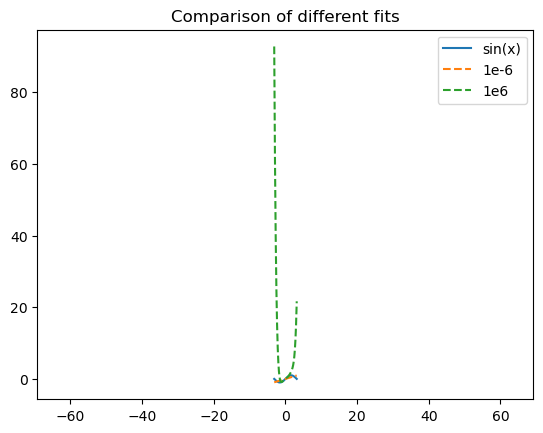

In [9]:
# You may use this cell to run your observations
#first figure
x = torch.linspace(-math.pi, math.pi, 1000)
# Original true values
y = torch.sin(x)
plt.plot(x, y, linestyle='solid', label='sin(x)')
# MSE
mse = lambda y_true, y_pred: torch.mean(torch.square(y_pred - y_true))
a ,b = polyfit(x, y, mse, 1, 1e-3, 5000)
y_pred_mse = a + b * x
plt.plot(x, y_pred_mse.detach().numpy(), linestyle='dashed', label=f'1e-6')

# MAE
mae = lambda y_true, y_pred: torch.mean(torch.abs(y_pred - y_true))
a, b, c, d,e,f,g = polyfit(x, y, mae, 6, 1e-3, 5000)
y_pred_mae = a + b * x + c * x ** 2 + d * x ** 3 + e * x ** 4 + f * x ** 5 + g * x ** 6
plt.plot(x, y_pred_mae.detach().numpy(), linestyle='dashed', label=f'1e6')

plt.axis('equal')
plt.title('Comparison of different fits')
plt.legend()
plt.show()



---
# 2 Computing gradients for arbitrary graphs

Recall the neural network for `y = |x-1|` from the lecture. We are going to implement forward propagation as mentioned during lecture. This forward pass is the act of feeding data into our input layer, which will then be passed to and processed by the hidden layers according to the different activation functions specific to each perceptron. After passing through all the hidden layers, our neural network will generate an output, $\hat{y}$, that is hopefully meaningful to our problem at hand.

![PyTorch](images/toy_nn.png)

### Task 2.1 - Forward pass

    In this task, you are required implement the function `forward_pass` that takes in 4 arguments:  
    1. `x`, the input values (not including bias)
    2. `w0`, (2x2) weights of the hidden layer
    3. `w1`, (3x1) weights of the output layer
    4. `activation_fn`, the activation function of the hidden layer.

*Note: As in the lecture, there will be no activation for the output layer (i.e. the activation function of the output layer is the identity function `lambda x: x`)*

In [10]:
# x = torch.linspace(-10, 10, 1000).reshape(-1, 1)
# y = torch.abs(x-1)
def forward_pass(x: torch.Tensor, w0: torch.Tensor, w1: torch.Tensor, activation_fn: Callable):
    """ YOUR CODE HERE """
    #since 1st row is bias 
    a1 = x @ w0[1:] + w0[0]
    z1 = activation_fn(a1)
    y_pred = z1 @ w1[1:] + w1[0]
    return y_pred
    raise NotImplementedError
    """ YOUR CODE END HERE """

# Exact weights
w0 = torch.tensor([[-1., 1.], [1., -1.]], requires_grad=True)
w1 = torch.tensor([[0.], [1.], [1.]], requires_grad=True)

# Performing a forward pass on exact solution for weights will give us the correct y values
x_sample = torch.linspace(-2, 2, 5).reshape(-1, 1)
forward_pass(x_sample, w0, w1, torch.relu) # tensor([[3.], [2.], [1.], [0.], [1.]])

tensor([[3.],
        [2.],
        [1.],
        [0.],
        [1.]], grad_fn=<AddBackward0>)

In [11]:
# Test cases
w0 = torch.tensor([[-1., 1.], [1., -1.]], requires_grad=True)
w1 = torch.tensor([[0.], [1.], [1.]], requires_grad=True)

output0 = forward_pass(torch.linspace(0,1,50).reshape(-1, 1), w0, w1, torch.relu)
x_sample = torch.linspace(-2, 2, 5).reshape(-1, 1)
test1 = forward_pass(x_sample, w0, w1, torch.relu).tolist()
output1 = [[3.], [2.], [1.], [0.], [1.]]

assert output0.shape == torch.Size([50, 1])
assert test1 == output1

### Task 2.2 - Backward propagation

In this task, you will start with random weights for `w0` and `w1`, and iteratively perform forward passes and backward propagation multiple times to converge on a solution.

Submit your values of `w0`, `w1`, and `loss` value onto Coursemology. Your `loss` value should be less than 1.

iter	loss	
----	----
1000	0.0008234531851485372
2000	0.00038421436329372227
3000	0.00020711480465251952
4000	0.00012338071246631444
5000	7.909521809779108e-05
6000	5.3592200856655836e-05
7000	3.795550583163276e-05
8000	2.7758227588492446e-05
9000	2.0960147594450973e-05
10000	1.614105531189125e-05
--- w0 ---
tensor([[-0.9330,  0.8714],
        [ 0.8643, -0.9466]], requires_grad=True)
--- w1 ---
tensor([[0.0788],
        [1.1572],
        [1.0566]], requires_grad=True)
loss:  1.6136986232595518e-05


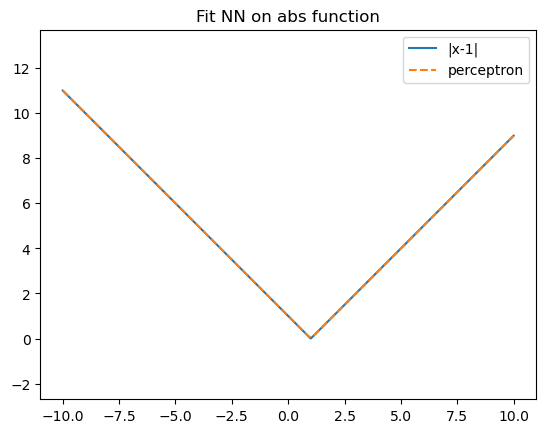

' YOUR CODE END HERE '

In [23]:
x = torch.linspace(-10, 10, 1000).reshape(-1, 1)
y = torch.abs(x-1)
torch.random.seed() # Set seed to some fixed value
w0 = torch.randn(2, 2, requires_grad=True)
w1 = torch.randn(3, 1, requires_grad=True)
learning_rate = 0.023
print('iter', 'loss', '\n----', '----', sep='\t')
for t in range(1, 10001):
    # Forward pass: compute predicted y
    y_pred = forward_pass(x, w0, w1, torch.relu)

    loss = torch.mean(torch.square(y - y_pred))
    loss.backward()

    if t % 1000 == 0:
        print(t, loss.item(), sep='\t')

    with torch.no_grad():
        """
        Update weights and then reset the gradients to zero here
        """
        w0 -= learning_rate * w0.grad
        w1 -= learning_rate * w1.grad
        w0.grad.zero_()
        w1.grad.zero_()

        
        
y_pred = forward_pass(x, w0, w1, torch.relu)
loss = torch.mean(torch.square(y - y_pred)).item()
print("--- w0 ---", w0, sep='\n')
print("--- w1 ---", w1, sep='\n')
print("loss: ", loss)
plt.plot(x, y, linestyle='solid', label='|x-1|')
plt.plot(x, y_pred.detach().numpy(), linestyle='dashed', label='perceptron')
plt.axis('equal')
plt.title('Fit NN on abs function')
plt.legend()
plt.show()

"""
paste your w0, w1 and loss values here
w0 = ...
w1 = ...
loss = ...
"""
""" YOUR CODE HERE """

""" YOUR CODE END HERE """

For manual.seed(1)
--- w0 ---
tensor([[-1.1936,  0.9731],
        [ 1.0735, -1.0955]], requires_grad=True)
--- w1 ---
tensor([[0.1103],
        [0.9318],
        [0.9130]], requires_grad=True)
loss:  4.485650788410567e-05

For manual.seed(2)
--- w0 ---
tensor([[-1.1554,  0.9102],
        [ 1.0522, -1.0089]], requires_grad=True)
--- w1 ---
tensor([[0.0968],
        [0.9506],
        [0.9913]], requires_grad=True)
loss:  3.021857628482394e-05

### Task 2.3 - Different random seeds

Try to fit the model on different initial random weight values by adjusting the random seed. 
<br/>
What is the impact of a random seed? How should we compare different neural network models given your observation to ensure fairness?

Submit your observations and conclusion on Coursemology.

---

# 3 Neural Networks (using PyTorch layers)

### Demo 3.1 - nn.Module

The `nn.Module` class is an interface that houses two main methods: `__init__`, where we instantiate our layers and activation functions, and `forward`, that performs the forward pass.

To create our own neural network, we will inherit from the nn.Module parent class and call `super().__init__()` from within our constructor to create our module. Next, we will implement the `forward` function within our class so we can call it from our module to perform the forward pass. 

In this example, we define a custom LinearLayer class that inherits from nn.Module. The __init__ method initializes the weight and bias parameters as nn.Parameter objects, which are special types of tensors that require gradients to be computed during the backward pass.

The forward method defines the forward pass of the linear layer. It takes a tensor x as input and computes the matrix multiplication of x and self.weight using the torch.matmul function, and then adds self.bias.

We also created our own activation function which uses `torch.sin` by inheriting from nn.Module.

Finally, in our Model, we can combine our own LinearLayers together with our SineActivation to process our input data using the forward function. In later sections, you will see how we can train our models.

In [ ]:
# Define a linear layer using nn.Module
class LinearLayer(nn.Module):
    """
    Linear layer as a subclass of `nn.Module`.
    """
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(input_dim, output_dim))
        self.bias = nn.Parameter(torch.randn(output_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.matmul(x, self.weight) + self.bias
    
class SineActivation(nn.Module):
    """
    Sine activation layer.
    """
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sin(x)

class Model(nn.Module):
    """
    Neural network created using `LinearLayer` and `SineActivation`.
    """
    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super(Model, self).__init__()
        self.l1 = LinearLayer(input_size, hidden_size)
        self.act = SineActivation()
        self.l2 = LinearLayer(hidden_size, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x
    
input_size = 1
hidden_size = 1
num_classes = 1

model = Model(input_size, hidden_size, num_classes)

x = torch.tensor([[1.0]])
output = model(x)
print("Original value: ", x)
print("Value after being processed by Model: ", output)

_Extra: We can also define a `backward` function to perform backpropagation which will not be required in this problem set._

In this trivial example, the Squared module takes an input x and returns x**2. The backward method calculates the gradient of the output with respect to the input, based on the gradients of the output grad_output.

We can define the backward function for functions that are not fully differentiable that we still wish to use in our neural network.

In [ ]:
class Squared(nn.Module):
    """
    Module that returns x**2.
    """
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.x = x
        return x**2

    def backward(self, grad_output: torch.Tensor) -> torch.Tensor:
        grad_input = 2 * self.x * grad_output
        return grad_input

### Demo 3.2 - Activation Functions

Pytorch also provides built-in activation functions. To help you understand more about activation functions, we have included some examples of activation functions introduced in the lecture, namely Sigmoid, Tanh, and ReLu. 

![PyTorch](images/img_activation_fns.png)

Activation functions introduces non-linearity into the output of a neuron, allowing the NN to learn non-linear functions. Without non-linearity, our entire network will effectively become a linear model with only one layer, preventing us from modelling complex representations based on our inputs.

Sigmoid, Tanh and ReLU are three examples of such activation functions introduced during lecture and the code block below shows how they map input to output values.

The choice of activation function for the hidden layers and the output layer depends on the problem you're trying to solve.

####  For the hidden layers, there are several commonly used activation functions:

ReLU (Rectified Linear Unit): ReLU is a popular activation function that is widely used in deep learning models. It maps non-positive inputs to 0 and positive inputs to their original value. It is mainly used in hidden layers because it is fast to compute, has sparse activations, and helps to mitigate the vanishing gradient problem, where the gradients can become very small and cause the model to learn slowly.

Tanh (Hyperbolic Tangent): Tanh is a activation function that maps input values to the range [-1, 1]. It is similar to Sigmoid, but instead of producing output values in the range [0, 1], it produces output values in the range [-1, 1]. Tanh is useful for solving problems where you want the activations to be centered around zero, such as in recurrent neural networks.

Sigmoid: Sigmoid maps its input values to the range [0, 1]. It is less commonly used in hidden layers because it has a relatively slow convergence rate and can introduce saturation, where the output values become very small or very large, which can make it difficult for the gradients to flow through the model.

#### For the output layer, the choice of activation function depends on the problem you're trying to solve. Here are some common choices:

Sigmoid: The Sigmoid activation function maps input values to the range [0, 1]. It is commonly used for binary classification problems where the network produces a probability of one of two classes. In this case, the Sigmoid activation maps the output to a probability distribution over the two classes.

Softmax: The Softmax activation function is a generalization of the Sigmoid activation that maps input values to a probability distribution over multiple classes. It is commonly used for multiclass classification problems. The Softmax activation function is used to convert the raw scores produced by the network into a probability distribution over the classes.

Linear: For regression problems, the linear activation function is often used because it just maps the input values to the output values without any change.

In summary, ReLU is a common choice for hidden layers, and the choice of activation function for the output layer depends on the problem you're trying to solve (binary classification, multiclass classification, or regression).

---

_Extra (Vanishing Gradient Problem):_

_Below is an image of the derivatives of the Sigmoid, Tanh and ReLU function. We can see that the derivatives for both Sigmoid and Tanh tend to zero when the inputs are largely positive or negative, while derivative for ReLU is zero only when the inputs are non-positive. In our neural network, gradients are calculated through backpropagation using chain rule and the derivatives of each layer are multiplied down the network. The gradient is more likely to decrease exponentially as we propagate down to the initial layers if we use Sigmoid and Tanh as compared to ReLU, leading to the vanishing gradient problem._

![PyTorch](images/img_activation_fns_der.png)


In [ ]:
x_sample = torch.linspace(-2, 2, 100)
sigmoid_output = nn.Sigmoid()(x_sample).detach().numpy()
tanh_output = nn.Tanh()(x_sample).detach().numpy()
relu_output = nn.ReLU()(x_sample).detach().numpy()

f = plt.figure()
f.set_figwidth(6)
f.set_figheight(6)
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title("Input: 100 x-values between -2 to 2 \n\n Output: Corresponding y-values after passed through each activation function\n", fontsize=16)
plt.axvline(x=0, color='r', linestyle='dashed')
plt.axhline(y=0, color='r', linestyle='dashed')
plt.plot(x_sample, sigmoid_output)
plt.plot(x_sample, tanh_output)
plt.plot(x_sample, relu_output)
plt.legend(["","","Sigmoid Output", "Tanh Output", "ReLU Output"])
plt.show()

### Task 3.1 - Forward pass (NN)

In part 2, you manually created the Linear layers and explicitly specified weights and biases for the forward pass to connect every input neuron to every output neuron which will be extremely tedious for larger networks. 

In this task, you will be using `nn.Linear(in_dimensions, out_dimensions)` provided by pytorch which abstracts all these details away. `nn.Linear` represents a fully connected layer with bias automatically included. We can also choose to remove the bias column by simply calling `nn.Linear(in_dimensions, out_dimensions, bias=False)` instead.

We inherit from PyTorch's `nn.Module` class to build the model from the previous task `y = |x-1|` from the lecture.  

![PyTorch](images/toy_nn.png)

Pytorch is widely used in machine learning due to the ease of being able to combine many different types of layers and activation functions to create neural networks. This task should allow you to appreciate how easily we can build neural networks using PyTorch.  

The model has been built for you in `__init__`. You need to implement the `forward` method, making use of the layers `self.l1`, `self.l2`, and the activation function `self.relu`. You need to combine the linear layers AND the activation function in the forward pass function!

_Extra: PyTorch has many other layers implemented for various model architectures.  
You can read more in the glossary as well as in the docs: https://pytorch.org/docs/stable/nn.html  
For now, we will only be using fully connected `nn.Linear` layers._

In [ ]:
class MyFirstNeuralNet(nn.Module):
    def __init__(self): # set the arguments you'd need
        super().__init__()
        self.l1 = nn.Linear(1, 2) # bias included by default
        self.l2 = nn.Linear(2, 1) # bias included by default
        self.relu = nn.ReLU()
 
    # Task 3.1: Forward pass
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Forward pass to process input through two linear layers and ReLU activation function.

        Parameters
        ----------
        x : A tensor of of shape (n, 1) where n is the number of training instances

        Returns
        -------
            Tensor of shape (n, 1)
        '''
        """ YOUR CODE HERE """
        raise NotImplementedError
        """ YOUR CODE END HERE """

In [ ]:
# Test cases
x_sample = torch.linspace(-2, 2, 5).reshape(-1, 1)

model = MyFirstNeuralNet()

state_dict = OrderedDict([
    ('l1.weight', torch.tensor([[1.],[-1.]])),
    ('l1.bias',   torch.tensor([-1., 1.])),
    ('l2.weight', torch.tensor([[1., 1.]])),
    ('l2.bias',   torch.tensor([0.]))
])

model.load_state_dict(state_dict)

student1 = model.forward(x_sample).detach().numpy()
output1 = [[3.], [2.], [1.], [0.], [1.]]

assert allclose(student1, output1, atol=1e-5)

### Demo 3.3 - Optimisers in PyTorch

Optimizers in PyTorch are used to update the parameters of a model during training. They do this by computing the gradients of the model's parameters with respect to the loss function, and then using these gradients to update the parameters in a way that minimizes the loss. 

In the following code example, we will simply demo a few basic functionalities of optimisers. Only in 3.1.4 Demo will you see an actual optimizer at work to train a Neural Net.

We first create a tensor x with requires_grad set to True. Next, we define our loss function to be the simple equation y = x ** 2 + 2 * x. Next, we define an optimiser (in this case, Stochastic Gradient Descent, SGD) and pass it our tensor x as a parameter to optimise. After updating the gradient stored in x using `backward()`, we will call the `step()` function to let the optimiser update x. We will then set the gradient of our tensor x back to zero using `zero_grad()`.

In [ ]:
x = torch.tensor([1.0], requires_grad=True)

#Loss function
y = x ** 2 + 2 * x

# Define an optimizer, pass it our tensor x to update
optimiser = torch.optim.SGD([x], lr=0.1)

# Perform backpropagation
y.backward()

print("Value of x before it is updated by optimiser: ", x)
print("Gradient stored in x after backpropagation: ", x.grad)

# Call the step function on the optimizer to update weight
optimiser.step()

#Weight update, x = x - lr * x.grad = 1.0 - 0.1 * 4.0 = 0.60
print("Value of x after it is updated by optimiser: ", x)

# Set gradient of weight to zero
optimiser.zero_grad()
print("Gradient stored in x after zero_grad is called: ", x.grad)

### Demo 3.4 - Training Your First Neural Net

Now, let's make use of an optimiser to train our neural network in Task 3.1!

Take note, if you make changes to your model (e.g. fix any bugs in your forward pass), then you will have to re-run your previous cell to update the model definition.

In the example below, we are applying what we have learnt in the above section about optimisers to train our neural network.

We will using `torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0)` as the optimiser. This SGD optimiser will implement stochastic gradient descent for us. As mentioned previously, `optimiser.zero_grad()` will set all the gradients to zero to prevent accumulation of all the previous old gradients we have calculated using backpropagation. `optimiser.step()` causes our optimiser to update the model weights based on the gradients of our parameters.

We can see clearly from our example below that we are calling `optimiser.zero_grad()` at the start of the loop so we can clear the gradient from the previous iteration of backpropagation. Then after we compute the loss in the current iteration using our loss function and model predictions, y_pred, we will call `loss.backward()` to let pytorch carry out the backpropagation for us. After backpropagation, gradients for each of our parameters will be computed for us to update our model weights using `optimiser.step()`.

In [ ]:
torch.manual_seed(6) # Set seed to some fixed value

epochs = 10000

model = MyFirstNeuralNet()
# the optimizer controls the learning rate
optimiser = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0)
loss_fn = nn.MSELoss()

x = torch.linspace(-10, 10, 1000).reshape(-1, 1)
y = torch.abs(x-1)

print('Epoch', 'Loss', '\n-----', '----', sep='\t')
for i in range(1, epochs+1):
    # reset gradients to 0
    optimiser.zero_grad()
    # get predictions
    y_pred = model(x)
    # compute loss
    loss = loss_fn(y_pred, y)
    # backpropagate
    loss.backward()
    # update the model weights
    optimiser.step()

    if i % 1000 == 0:
        print (f"{i:5d}", loss.item(), sep='\t')

y_pred = model(x)
plt.plot(x, y, linestyle='solid', label='|x-1|')
plt.plot(x, y_pred.detach().numpy(), linestyle='dashed', label='perceptron')
plt.axis('equal')
plt.title('Fit NN on y=|x-1| function')
plt.legend()
plt.show()

### Concept 3.1 - Save and load models

Your model weights are stored within the model itself.  
You may save/load the model weights:
```
torch.save(model.state_dict(), "path/to/model_state_dict")

model = MyFirstNeuralNet()
model.load_state_dict(torch.load("path/to/model_state_dict"))
```

Alternatively, you can save/load the entire model using
```
torch.save(model, "path/to/model")

model = torch.load("path/to/model")
```

### Task 3.2 - Model weights

For this task, you will print out the trained model's `.state_dict()` and submit this to Coursemology.

*Note: An acceptable loss value should be less than 1.0. If your loss is greater than 1, try re-running with a different random initialization, or adjust your model configuration.*

In [ ]:
# To submit this output
print("--- Submit the OrderedDict below ---")
print(model.state_dict())
"""
state_dict = OrderedDict([]) # paste the output in
"""
""" YOUR CODE HERE """
raise NotImplementedError
""" YOUR CODE END HERE """

In [ ]:
def get_loss(model: nn.Module) -> int | float:
    model.load_state_dict(state_dict)
    x = torch.linspace(-10, 10, 1000).reshape(-1, 1)
    y = torch.abs(x-1)
    loss_fn = nn.MSELoss()
    y_pred = model.forward(x)
    return loss_fn(y_pred, y).item()

assert model.load_state_dict(state_dict)
assert get_loss(model) < 1

### Concept 3.2 - Using NN to recognize handwritten digits

Now we will be building a neural network to classify images to their respective digits.  

You will build and train a model on the classic **MNIST Handwritten Digits** dataset. Each grayscale image is a $28 \times 28$ matrix/tensor that looks like so:

<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" width="500" />

MNIST is a classification problem and the task is to take in an input image and classify them into one of ten buckets: the digits from $0$ to $9$. 

### Demo 3.5 - Loading an external dataset

The cell below imports the MNIST dataset, which is already pre-split into train and test sets.  

The download takes approximately 63MB of space.

In [ ]:
# DO NOT REMOVE THIS CELL – THIS DOWNLOADS THE MNIST DATASET
# RUN THIS CELL BEFORE YOU RUN THE REST OF THE CELLS BELOW
from torchvision import datasets

# This downloads the MNIST datasets ~63MB
mnist_train = datasets.MNIST("./", train=True, download=True)
mnist_test  = datasets.MNIST("./", train=False, download=True)

x_train = mnist_train.data.reshape(-1, 784) / 255
y_train = mnist_train.targets
    
x_test = mnist_test.data.reshape(-1, 784) / 255
y_test = mnist_test.targets

### Task 3.3 - Define the model architecture and implement the forward pass
Create a 3-layer network in the `__init__` method of the model `DigitNet`.  
These layers are all `Linear` layers and should correspond to the following the architecture:

![PyTorch](images/img_linear_nn.png)

In our data, a given image $x$ has been flattened from a 28x28 image to a 784-length array.

After initializing the layers, stitch them together in the `forward` method. Your network should look like so:

$$x \rightarrow \text{Linear(512)} \rightarrow \text{ReLU} \rightarrow \text{Linear(128)} \rightarrow \text{ReLU} \rightarrow \text{Linear(10)} \rightarrow \text{Softmax} \rightarrow \hat{y}$$

**Softmax Layer**: The final softmax activation is commonly used for classification tasks, as it will normalizes the results into a vector of values that follows a probability distribution whose total sums up to 1. The output values are between the range [0,1] which is nice because we are able to avoid binary classification and accommodate as many classes or dimensions in our neural network model.

*Note: When using `torch.softmax(...)` on the final layer, ensure you are applying it on the correct dimension (as you did in NumPy via the `axis` argument in popular methods)*

In [ ]:
class DigitNet(nn.Module):
    def __init__(self, input_dimensions: int, num_classes: int): # set the arguments you'd need
        super().__init__()
        """
        YOUR CODE HERE
        - DO NOT hardcode the input_dimensions, use the parameter in the function
        - Your network should work for any input and output size 
        - Create the 3 layers (and a ReLU layer) using the torch.nn layers API
        """
        """ YOUR CODE HERE """
        raise NotImplementedError
        """ YOUR CODE END HERE """
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs the forward pass for the network.
        
        Parameters
        ----------
        x : Input tensor (batch size is the entire dataset)

        Returns
        -------
            The output of the entire 3-layer model.
        """
        
        """
        YOUR CODE
        
        - Pass the inputs through the sequence of layers
        - Run the final output through the Softmax function on the right dimension!
        """
        """ YOUR CODE HERE """
        raise NotImplementedError
        """ YOUR CODE END HERE """

In [ ]:
# Test cases
model = DigitNet(784, 10)
assert [layer.detach().numpy().shape for name, layer in model.named_parameters()] \
        == [(512, 784), (512,), (128, 512), (128,), (10, 128), (10,)]

### Task 3.4 - Training Loop

As demonstrated in Section 3.2, implement the function `train_model` that performs the following for every epoch/iteration:

1. set the optimizer's gradients to zero
2. forward pass
3. calculate the loss
4. backpropagate using the loss
5. take an optimzer step to update weights

This time, use the Adam optimiser to train the network.
<br/>
<br/>
Use Cross-Entropy Loss, since we are performing a classification.
<br/>
_(PyTorch Softmax normalize logits while CrossEntropyLoss accepts unnormalized logits and CrossEntropyLoss already applies LogSoftmax, however, we will use Softmax here as we want to showcase how Softmax can convert the raw scores produced by the network into a probability distribution over the classes)._
<br/>
<br/>
Train for 20 epochs.  

*Note: refer to the command glossary to find out how to instantiate optimisers, losses, and more*

In [ ]:
def train_model(x_train: torch.Tensor, y_train: torch.Tensor, epochs: int = 20):
    """
    Trains the model for 20 epochs/iterations
    
    Parameters
    ----------
        x_train : A tensor of training features of shape (60000, 784)
        y_train : A tensor of training labels of shape (60000, 1)
        epochs  : Number of epochs, default of 20
        
    Returns
    -------
        The final model 
    """
    model = DigitNet(784, 10)

    optimiser = torch.optim.Adam(model.parameters()) # use Adam
    loss_fn = nn.CrossEntropyLoss()   # use CrossEntropyLoss

    for i in range(epochs):
        """ YOUR CODE HERE """
        raise NotImplementedError
        """ YOUR CODE END HERE """

    return model
                
digit_model = train_model(x_train, y_train)

In [ ]:
# Test cases
x_train_new = torch.rand(5, 784, requires_grad=True)
y_train_new = ones = torch.ones(5, dtype=torch.uint8)

assert type(train_model(x_train_new, y_train_new)) == DigitNet

### Demo 3.6 - Explore your model

Now that we have trained the model, let us run some predictions on the model.

In [ ]:
# This is a demonstration: You can use this cell for exploring your trained model

idx = 0 # try on some index

scores = digit_model(x_test[idx:idx+1])
_, predictions = torch.max(scores, 1)
print("true label:", y_test[idx].item())
print("pred label:", predictions[0].item())

plt.imshow(x_test[idx].numpy().reshape(28, 28), cmap='gray')
plt.axis("off")
plt.show()

### Task 3.5 - Evaluate the model

Now that we have trained the model, we should evaluate it using our test set.  
We will be using the accuracy (whether or not the model predicted the correct label) to measure the model performance.  

Since our model takes in a (n x 784) tensor and returns a (n x 10) tensor of probability scores for each of the 10 classes, we need to convert the probability scores into the actual predictions by taking the index of the maximum probability.  

In [ ]:
def get_accuracy(scores: torch.Tensor, labels: torch.Tensor) -> int | float:
    """
    Helper function that returns accuracy of model
    
    Parameters
    ----------
        scores : The raw softmax scores of the network
        labels : The ground truth labels
        
    Returns
    -------
        Accuracy of the model. Return a number in range [0, 1].
        0 means 0% accuracy while 1 means 100% accuracy
    """
    """ YOUR CODE HERE """
    raise NotImplementedError
    """ YOUR CODE END HERE """
scores = digit_model(x_test) # n x 10 tensor
get_accuracy(scores, y_test)

In [ ]:
# Test cases
scores = torch.tensor([[0.4118, 0.6938, 0.9693, 0.6178, 0.3304, 0.5479, 0.4440, 0.7041, 0.5573,
         0.6959],
        [0.9849, 0.2924, 0.4823, 0.6150, 0.4967, 0.4521, 0.0575, 0.0687, 0.0501,
         0.0108],
        [0.0343, 0.1212, 0.0490, 0.0310, 0.7192, 0.8067, 0.8379, 0.7694, 0.6694,
         0.7203],
        [0.2235, 0.9502, 0.4655, 0.9314, 0.6533, 0.8914, 0.8988, 0.3955, 0.3546,
         0.5752],
        [0,0,0,0,0,0,0,0,0,1]])
y_true = torch.tensor([5, 3, 6, 4, 9])
acc_true = 0.4
assert isclose(get_accuracy(scores, y_true),acc_true) , "Mismatch detected"
print("passed")

# 4 Vision Layers
Here, you'll be building the two fundamental layers that are the cornerstone of Computer Vision: the convolutional layer and the pooling layer (specifically, __max__ pooling). 

## Task 4.1: Convolution Under The Hood

Your task is to write the `conv2d` function that performs the convolution operation on a 2-dim image, `img : torch.Tensor`, using a certain kernel, `kernel : torch.Tensor`. Assume there is no padding and the stride is 1. 

> Don't work on the channels – assume they remain the same. Your code should only work on the spatial dimensions: Height and Width.

We've given you two images `x1` and `x2` and their convolutional outputs `c1` and `c2` respectively. Run them to verify whether your function is working as expected.

$$
c1 = \texttt{conv2d}\Bigg(
\begin{bmatrix}
    4 & 9 & 3 & 0 & 3 \\
    9 & 7 & 3 & 7 & 3 \\
    1 & 6 & 6 & 9 & 8 \\
    6 & 6 & 8 & 4 & 3 \\
    6 & 9 & 1 & 4 & 4 \\
\end{bmatrix},~
\begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}\Bigg) = 
    \begin{bmatrix} 
        4+9+9+7 & 9+3+7+3 & 3+0+3+7 & 0+3+7+3 \\
        9+7+1+6 & 7+3+6+6 & 3+7+6+9 & 7+3+9+8  \\
        1+6+6+6 & 6+6+6+8 & 6+9+8+4 & 9+8+4+3 \\
        6+6+6+9 & 6+8+9+1 & 8+4+1+4 & 4+3+4+4 \\
    \end{bmatrix} =
\begin{bmatrix} 
        29 & 22 & 13 & 13 \\
        23 & 22 & 25 & 27  \\
        19 & 26 & 27 & 24 \\
        27 & 24 & 17 & 15 \\
\end{bmatrix}
$$

$$
c2 = \texttt{conv2d}\Bigg(
\begin{bmatrix}
    1 & 9 & 9 & 9 & 0 & 1 \\
    2 & 3 & 0 & 5 & 5 & 2 \\
    9 & 1 & 8 & 8 & 3 & 6 \\
    9 & 1 & 7 & 3 & 5 & 2 \\
    1 & 0 & 9 & 3 & 1 & 1 \\
    0 & 3 & 6 & 6 & 7 & 9 \\
\end{bmatrix},~
\begin{bmatrix}
    6 & 3 & 4 & 5 \\
    0 & 8 & 2 & 8 \\
    2 & 7 & 5 & 0 \\
    0 & 8 & 1 & 9 \\
\end{bmatrix}\Bigg) = \begin{bmatrix} 
    285 & 369 & 286 \\
    230 & 317 & 257 \\ 
    306 & 374 & 344 \\
\end{bmatrix}
$$

__Note:__ You are not allowed to use the `torch.nn.functional.conv2d` function. But nested loop is allowed here.

In [ ]:
torch.manual_seed(0)

def conv2d(img: torch.Tensor, kernel: torch.Tensor):
    """
    PARAMS
        img: the 2-dim image with a specific height and width
        kernel: a 2-dim kernel (smaller than image dimensions) that convolves the given image
    
    RETURNS
        the convolved 2-dim image
    """
    """ YOUR CODE HERE """
    raise NotImplementedError
    """ YOUR CODE END HERE """

In [ ]:
# Test cases
x1 = torch.tensor([
    [4, 9, 3, 0, 3],
    [9, 7, 3, 7, 3],
    [1, 6, 6, 9, 8],
    [6, 6, 8, 4, 3],
    [6, 9, 1, 4, 4]
])
k1 = torch.ones((2, 2))
o1 = torch.tensor([
    [29., 22., 13., 13.],
    [23., 22., 25., 27.],
    [19., 26., 27., 24.],
    [27., 24., 17., 15.]
])

x2 = torch.tensor([
    [1, 9, 9, 9, 0, 1],
    [2, 3, 0, 5, 5, 2],
    [9, 1, 8, 8, 3, 6],
    [9, 1, 7, 3, 5, 2],
    [1, 0, 9, 3, 1, 1],
    [0, 3, 6, 6, 7, 9]
])
k2 = torch.tensor([
    [6, 3, 4, 5],
    [0, 8, 2, 8],
    [2, 7, 5, 0],
    [0, 8, 1, 9]
])
o2 = torch.tensor([
    [285., 369., 286.],
    [230., 317., 257.],
    [306., 374., 344.]
])

# TEST YOUR conv2d FUNCTION HERE
c1 = conv2d(x1, k1)
print(c1, torch.all(torch.eq(c1, o1)).item())
c2 = conv2d(x2, k2)
print(c2, torch.all(torch.eq(c2, o2)).item())

## Task 4.2: Max Pooling Under The Hood

Your task is to write the `maxpool2d` function that takes in an image, `img : torch.Tensor`, and a square kernel size `size : int`. Assume stride is 1 and there's no padding.

We've given you two images `x1` and `x2` to test your `maxpool2d` function with `size=2` and `size=3` respectively.  
$$
m1 = \texttt{maxpool2d}\Bigg(
\begin{bmatrix}
    4 & 9 & 3 & 0 & 3 \\
    9 & 7 & 3 & 7 & 3 \\
    1 & 6 & 6 & 9 & 8 \\
    6 & 6 & 8 & 4 & 3 \\
    6 & 9 & 1 & 4 & 4 \\
\end{bmatrix},~2\Bigg) =
\begin{bmatrix} 
        max(4,9,9,7) & max(9,3,7,3) & max(3,0,3,7) & max(0,3,7,3) \\
        max(9,7,1,6) & max(7,3,6,6) & max(3,7,6,9) & max(7,3,9,8)  \\
        max(1,6,6,6) & max(6,6,6,8) & max(6,9,8,4) & max(9,8,4,3) \\
        max(6,6,6,9) & max(6,8,9,1) & max(8,4,1,4) & max(4,3,4,4) \\
\end{bmatrix} =
\begin{bmatrix} 
        9 & 9 & 7 & 7 \\
        9 & 7 & 9 & 9  \\
        6 & 8 & 9 & 9 \\
        9 & 9 & 8 & 4 \\
\end{bmatrix}
$$

$$
m2 = \texttt{maxpool2d}\Bigg(
\begin{bmatrix}
    1 & 9 & 9 & 9 & 0 & 1 \\
    2 & 3 & 0 & 5 & 5 & 2 \\
    9 & 1 & 8 & 8 & 3 & 6 \\
    9 & 1 & 7 & 3 & 5 & 2 \\
    1 & 0 & 9 & 3 & 1 & 1 \\
    0 & 3 & 6 & 6 & 7 & 9 \\
\end{bmatrix},~3\Bigg) = \begin{bmatrix} 
    9 & 9 & 9 & 9 \\
    9 & 8 & 8 & 8 \\ 
    9 & 9 & 9 & 8 \\
    9 & 9 & 9 & 9 \\
\end{bmatrix}
$$

__Note:__ You are not allowed to use the `torch.nn.functional.max_pool2d` function.

In [ ]:
torch.manual_seed(0)

def maxpool2d(img: torch.Tensor, size: int):
    """
    PARAMS
        img: the 2-dim image with a specific height and width
        size: an integer corresponding to the window size for Max Pooling
    
    RETURNS
        the 2-dim output after Max Pooling
    """
    """ YOUR CODE HERE """
    raise NotImplementedError
    """ YOUR CODE END HERE """

In [ ]:
# Test cases
x1 = torch.tensor([
    [4, 9, 3, 0, 3],
    [9, 7, 3, 7, 3],
    [1, 6, 6, 9, 8],
    [6, 6, 8, 4, 3],
    [6, 9, 1, 4, 4]
])
k1 = 2
o1 = torch.tensor([
    [9., 9., 7., 7.],
    [9., 7., 9., 9.],
    [6., 8., 9., 9.],
    [9., 9., 8., 4.]
])

x2 = torch.tensor([
    [1, 9, 9, 9, 0, 1],
    [2, 3, 0, 5, 5, 2],
    [9, 1, 8, 8, 3, 6],
    [9, 1, 7, 3, 5, 2],
    [1, 0, 9, 3, 1, 1],
    [0, 3, 6, 6, 7, 9]
])
k2 = 3
o2 = torch.tensor([
    [9., 9., 9., 9.],
    [9., 8., 8., 8.],
    [9., 9., 9., 8.],
    [9., 9., 9., 9.]
])

# TEST YOUR maxpool2d FUNCTION HERE
m1 = maxpool2d(x1, k1)
print(m1, torch.all(torch.eq(m1, o1)).item())
m2 = maxpool2d(x2, k2)
print(m2, torch.all(torch.eq(m2, o2)).item())

# 5: MNIST Classification with CNNs

We will be working on the MNIST handwritten digits classification problem again but this time with CNNs. You'll be working the images as they are in the form of $1 \times 28 \times 28$ tensors, where $28$ is the image height and width, and $1$ is the number of colour channels (grayscale image in this case).

In [ ]:
# do not remove this cell
# run this before moving on

T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

"""
Note: If you updated the path to the directory containing `MNIST` 
directory, please update it here as well.
"""
mnist_train = datasets.MNIST("./", train=True, download=False, transform=T)
mnist_test = datasets.MNIST("./", train=False, download=False, transform=T)

"""
if you feel your computer can't handle too much data, you can reduce the batch
size to 64 or 32 accordingly, but it will make training slower. 

We recommend sticking to 128 but do choose an appropriate batch size that your
computer can manage. The training phase tends to require quite a bit of memory.
"""
train_loader = torch.utils.data.DataLoader(mnist_train, shuffle=True, batch_size=256)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=10000)

## Concept 5.1: DataLoaders

PyTorch __DataLoaders__ accept datasets and can iterate through the datasets as we deem fit.

`train_loader = torch.utils.data.DataLoader(mnist_train, shuffle=True, batch_size=256)` means that this dataloader takes in the MNIST training data, and outputs training features and labels in batches of 256. It also reshuffles all the data in the dataset for the next epoch once it has outputted all the data in the dataset.

Run the following code to get a better idea of how dataloaders work.

In [ ]:
# no need to code
# run this before moving on

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()
print(f"Label: {label}")

## Task 5.1: Building a Vanilla ConvNet

Your task here is to build a ConvNet using PyTorch layers. You can refer to the attached command glossary to read more about the layers. Use the following architecture:

$$
\text{Conv(32, (3,3))} \rightarrow \text{MP(2,2)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{Conv(64, (3,3))} \rightarrow \text{MP(2,2)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{Flat} \\ \rightarrow \text{L(1600, 256)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{L(256, 128)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{L(128, 10)} \rightarrow \text{Softmax}
$$

where 
- [`Conv`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) is a Convolution layer with the specified output channels and kernel size, with no padding and a stride of 1 by default.

- [`MP`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) is the Max Pooling layer with the specified kernel size, with no padding, the stride set to the same shape as the kernel by default.

- [`LReLU`](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) is Leaky ReLU with the specified negative slope.

- `Flat` is the flattening operation, which should flatten/reshape the tensor from a multi-dimensional tensor (batch_size, num_channels, width, height) into a "flat" tensor (batch_size, num_channels x width x height). The 2-dimensional result represents that each sample has only 1 dimension of "flattened" data. This has already been implemented for you

- [`L`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) is a fully-connected layer with the specified input and output features.

__Note:__ For all your networks hereon, the only constructor argument is `classes`. Do not add any other parameters to the `__init__` method. Remember not to hardcode for the number of classes and use the `classes` argument instead.

__Note:__ There is no need to include a Softmax layer in your neural network, as technically, [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) which we are going to use as our loss function later, already applies Softmax implicitly.

In [ ]:
class RawCNN(nn.Module):
    """
    CNN model using Conv2d and MaxPool2d layers.
    """
    def __init__(self, classes: int):
        super().__init__()
        """
        classes: integer that corresponds to the number of classes for MNIST
        """
        """ YOUR CODE HERE """
        raise NotImplementedError
        """ YOUR CODE END HERE """
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ YOUR CODE HERE """
        raise NotImplementedError
        """ YOUR CODE END HERE """
        
        x = x.view(-1, 64*5*5) # Flattening – do not remove this line

        """ YOUR CODE HERE """
        raise NotImplementedError
        """ YOUR CODE END HERE """


# Test cases
# Test your network's forward pass
num_samples, num_channels, width, height = 20, 1, 28, 28
x = torch.rand(num_samples, num_channels, width, height)
net = RawCNN(10)
y = net(x)
print(y.shape) # torch.Size([20, 10])

## Concept 5.2: Dropout

__Dropout__ (*Srivastava et al., 2014*) is a regularisation technique that randomly shuts off neurons in a given layer. This means the output of the neuron is __zero__. As users, we need to specify a probability value `p` that is the probability of a neuron being shut off or not; there's a $p$ chance of a neuron being shut off.

Suppose a layer has $n$ neurons/units. Mathematically, 

$$
\text{Prob}(i = 1) = p \\
\text{Prob}(i = 0) = 1 - p
$$ 

where $i \in \{1, \dots, n\}$ and $1$ represents neuron $i$ being shut off and $0$ represents neuron $0$ left untouched.

Essentially, Dropout does this:

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-23_at_6.19.24_PM.png" width=600>

### Why Dropout works
By randomly dropping/zero-ing out neurons in a layer, it has a regularising effect on the model. It prevents overfitting because the loss of certain features means the model doesn't accidentally compute very complex functions to model the relationship between $x$ and $y$.

#### Dropout in PyTorch
To use Dropout in a network, we can create a `Dropout` layer in our `__init__` method of the model class:

```python
class Model(nn.Module):
    def __init__(self, ..., drop_prob):
        super().__init__()
        self.l1 = ...
        ...
        self.dropout = nn.Dropout(p=drop_prob)
        ...
        self.ln = ...
   
    def forward(self, x):
        x = self.l1(x)
        ...
        x = self.dropout(x)
        ...
        out = ...
        
        return out
```

__Note:__ Other that `nn.Dropout`, there is a `nn.Dropout2d` in PyTorch. Instead of randomly zero-ing out neurons, `Dropout2d` randomly zero-es out the entire channels of the input. 

`nn.Dropout` is best used with non-spatial data or data that has been flattened, which is typical for fully connected layers. `nn.Dropout2d` is designed for spatial data, making it ideal for use right after convolutional and pooling layers in CNNs.

For the sake of this problem set, You should choose one of them to be but __NOT both__ in your neural network.

---

## Task 5.2: Building a ConvNet with Dropout

Here, you must build the exact same network but with Dropout inside the architecture. You can refer to the attached command glossary to read more about the layers. Use the following architecture:

$$
\text{Conv(32, (3,3))} \rightarrow \text{MP(2,2)} \rightarrow \text{LReLU(0.1)} \rightarrow \textbf{DO(prob)} \rightarrow \\
\text{Conv(64, (3,3))} \rightarrow \text{MP(2,2)} \rightarrow \text{LReLU(0.1)} \rightarrow \textbf{DO(prob)} \rightarrow \\
\text{Flat} \rightarrow \text{L(1600, 256)} \rightarrow \text{LReLU(0.1)} \rightarrow \textbf{DO(prob)} \rightarrow \\
\text{L(256, 128)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{L(128, 10)} \rightarrow \text{Softmax}
$$

where 
- [`Conv`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) is a Convolution layer with the specified output channels and kernel size, with no padding and a stride of 1 by default.

- [`MP`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) is the Max Pooling layer with the specified kernel size, with no padding, the stride set to the same shape as the kernel by default.

- [`LReLU`](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) is Leaky ReLU with the specified negative slope.

- `Flat` is the flattening operation, which should flatten/reshape the tensor from a multi-dimensional tensor (batch_size, num_channels, width, height) into a "flat" tensor (batch_size, num_channels x width x height). The 2-dimensional result represents that each sample has only 1 dimension of "flattened" data. This has already been implemented for you

- [`L`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) is a fully-connected layer with the specified input and output features.
 
- [`DO`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) is Dropout with a dropping probability. Choose between `nn.Dropout` and `nn.Dropout2d` but __not both__ for your network.

You are highly encouraged to initialise all your layers in the `__init__` method.

__Reminder:__ Do not hardcode for the number of classes and the dropout probability. Use the `classes` and `drop_prob` constructor arguments instead.

__Note:__ There is no need to include a Softmax layer in your neural network, as technically, [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) which we are going to use as our loss function later, already applies Softmax implicitly.

In [ ]:
class DropoutCNN(nn.Module):
    """
    CNN that uses Conv2d, MaxPool2d, and Dropout layers.
    """
    def __init__(self, classes: int, drop_prob: float = 0.5):
        super().__init__()
        """
        classes: integer that corresponds to the number of classes for MNIST
        drop_prob: probability of dropping a node in the neural network
        """
        """ YOUR CODE HERE """
        raise NotImplementedError
        """ YOUR CODE END HERE """
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ YOUR CODE HERE """
        raise NotImplementedError
        """ YOUR CODE END HERE """
        
        x = x.view(-1, 64*5*5) # Flattening – do not remove

        """ YOUR CODE HERE """
        raise NotImplementedError
        """ YOUR CODE END HERE """



# Test cases
# Test your network's forward pass
num_samples, num_channels, width, height = 20, 1, 28, 28
x = torch.rand(num_samples, num_channels, width, height)
net = DropoutCNN(10)
y = net(x)
print(y.shape) # torch.Size([20, 10])

## Task 5.3: Training your Vanilla and Dropout CNNs

Here, write down the training loop in the function `train_model` to train the CNNs you have just created. It will take in the respective NN (vanilla or dropout), as well as training and testing __data loaders__ (more on this later) that return batches of images and their respective labels to train on. 

Use the `torch.optim.Adam(...)` optimizer and Cross Entropy Loss.

> Return the model and epoch losses.

Remember to extract the loss value from the `loss` tensor by using `loss.item()`.

__Tip:__ Don't be worried if your model takes a while to train. Your mileage may also vary depending on your CPU. But if you would like to speed things up, you can consider making use of your device's GPU to parallelize the matrix computations.

In [ ]:
%%time 
# do not remove the above line
def train_model(loader: torch.utils.data.DataLoader, model: nn.Module):
    """
    PARAMS
    loader: the data loader used to generate training batches
    model: the model to train
  
    RETURNS
        the final trained model and losses
    """

    """
    YOUR CODE HERE
    
    - create the loss and optimizer
    """
    """ YOUR CODE HERE """
    raise NotImplementedError
    """ YOUR CODE END HERE """
    epoch_losses = []
    model = model.to(device)
    for i in range(10):
        epoch_loss = 0
        model.train()
        for idx, data in enumerate(loader):
            # Note that you may need to pass the tensor(s) to the device
            # using .to(device).
            """
            YOUR CODE HERE
            
            - reset the optimizer
            - perform forward pass
            - compute loss
            - perform backward pass
            """
            """ YOUR CODE HERE """
            raise NotImplementedError
            """ YOUR CODE END HERE """

        epoch_loss = epoch_loss / len(loader)
        epoch_losses.append(epoch_loss)
        print ("Epoch: {}, Loss: {}".format(i, epoch_loss))
        

    return model, epoch_losses

print("======Training Vanilla Model======")
vanilla_model, losses = train_model(train_loader, RawCNN(10))
print("======Training Dropout Model======")
do_model, losses = train_model(train_loader, DropoutCNN(10))

In [ ]:
# do not remove – nothing to code here
# run this cell before moving on
# but ensure get_accuracy from task 3.5 is defined

with torch.no_grad():
    vanilla_model.eval()
    for i, data in enumerate(test_loader):
        x, y = data
        x, y = x.to(device), y.to(device)
        pred_vanilla = vanilla_model(x)
        acc = get_accuracy(pred_vanilla, y)
        print(f"vanilla acc: {acc}")
        
    do_model.eval()
    for i, data in enumerate(test_loader):
        x, y = data
        x, y = x.to(device), y.to(device)
        pred_do = do_model(x)
        acc = get_accuracy(pred_do, y)
        print(f"drop-out (0.5) acc: {acc}")
        
"""
The network with Dropout might under- or outperform the network without
Dropout. However, in terms of generalisation, we are assured that the Dropout
network will not overfit – that's the guarantee of Dropout.

A very nifty trick indeed!
"""

## Task 5.4: Observing Effects of Dropout

Here, train your `DropoutCNN` with your `train_model(loader, model)` from Task 5.3, but with `p=0.1` and `p=0.95` respectively. 

Explain why extreme values of Dropout don't work as well on neural networks. Look back at first principles – what does Dropout do in the first place? How does the `p` value affect how it does it? 

In [ ]:
%%time 
# do not remove – nothing to code here
# run this before moving on

print("======Training Dropout Model with Dropout Probability 0.10======")
do10_model, do10_losses = train_model(train_loader, DropoutCNN(10, 0.10))
print("======Training Dropout Model with Dropout Probability 0.95======")
do95_model, do95_losses = train_model(train_loader, DropoutCNN(10, 0.95))

In [ ]:
# do not remove – nothing to code here
# run this cell before moving on
# but ensure get_accuracy from task 3.5 is defined

with torch.no_grad():
    do10_model.eval()
    for i, data in enumerate(test_loader):
        x, y = data
        x, y = x.to(device), y.to(device)
        pred_do = do10_model(x)
        acc = get_accuracy(pred_do, y)
        print(acc)

    do95_model.eval()
    for i, data in enumerate(test_loader):
        x, y = data
        x, y = x.to(device), y.to(device)
        pred_do = do95_model(x)
        acc = get_accuracy(pred_do, y)
        print(acc)

# Chapter 6: Training on CIFAR-10

## Concept 6.1: CIFAR-10
Using what you've learned with MNIST, apply the techniques to CIFAR-10, a dataset of 60K training and 10K testing images comprising of real-life objects corresponding to the following 10 classes:

- airplane										
- automobile										
- bird										
- cat										
- deer										
- dog										
- frog										
- horse										
- ship										
- truck

Each image is $3 \times 32 \times 32$, meaning we operate on 3 color channels RGB. Some of these images look like so:

![PyTorch](images/cifar.jpg)

## Concept 6.2: Data Augmentation

In reality, however, finding a well-representative, balanced dataset is difficult. To address this issue, we use __Data Augmentation__. It refers to the process of transforming data in a training dataset in one or more ways to create more samples to expand the training dataset.

Here, we will pick images from the original dataset `x_train`, perform some transformations $F$ on them, and append them to `x_train`. So, for example, if I have a training dataset of 200 car images, I can perform augmentations on the 200 images to get 300 more images, thereby making my new training dataset 500 images large.

Of course, the impact of data augmentation on model training depends on the types of augmentation used. Here are some common ones Computer Vision practitioners use:

- Normalisation
- Horizontal and Vertical Flipping
- Rotation
- Blurring
- Adding noise
- Skewing
- Cropping (zooming in or out)
- Brightness and Contrast
- Shuffling pixels

This results in a wide variety of new samples being created that can be used for training.

## The `transforms` module

Here, we are going to use the `transforms` module from PyTorch to transform the images in our dataset. It contains all kinds of image transformations from `rotate` to `resize`. Check out the full list of augmentations on the PyTorch documentation: https://pytorch.org/vision/stable/transforms.html.

Explore the following example to see how the transformations work.

In [ ]:
cifar_train = datasets.CIFAR10("./", train=True, download=True, transform=transforms.ToTensor())
cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=128, shuffle=True)

train_features, train_labels = next(iter(cifar_train_loader))
img = train_features[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
transform = transforms.Compose([transforms.RandomHorizontalFlip()
                                # YOUR CODE HERE
                                ]) # add in your own transformations to test
tensor_img = transform(img)
ax1.imshow(img.permute(1,2,0))
ax1.axis("off")
ax1.set_title("Before Transformation")
ax2.imshow(tensor_img.permute(1, 2, 0))
ax2.axis("off")
ax2.set_title("After Transformation")
plt.show()

## Task 6.1: Picking Data Augmentations

Your task is to pick your favourite data augmentations and apply them to the images from the dataset (in the later cell). 

We've already started you off with the necessary one `ToTensor()` that converts the original JPEG-format image to the PyTorch `Tensor` format. Refer to the command glossary to add your custom data augmentations from the list we've provided. 

**Choose at least 2 additional augmentations.** Tell us which augmentations you chose to use _and_ why. Then tell us which augmentations you avoided _and_ why. 

__Note:__ Feel free to use any augmentations you wish from the full list of augmentations shown on the [PyTorch documentation](https://pytorch.org/vision/stable/transforms.html)! There's no need to be restricted to the list that we've provided.

The point is to improve your model performance as much as possible! Use trial and error to get the best performing network in Task 3.2!

Be creative :D

__Note:__ Do ensure your augmentations retain the 3-dimensional shape of the CIFAR-10 images. The final images should still have the shape `(3, 32, 32)`.

In [ ]:
# pick your data augmentations here
def get_augmentations() -> transforms.Compose:
    T = transforms.Compose([
        transforms.ToTensor(),
        """ YOUR CODE HERE """
        raise NotImplementedError
        """ YOUR CODE END HERE """
    ])
    
    return T

Create your data loaders that return batches of data:

In [ ]:
# do not remove this cell
# run this before moving on

T = get_augmentations()

cifar_train = datasets.CIFAR10("./", train=True, download=True, transform=T)
cifar_test = datasets.CIFAR10("./", train=False, download=True, transform=T)

"""
if you feel your computer can't handle too much data, you can reduce the batch
size to 64 or 32 accordingly, but it will make training slower. 

We recommend sticking to 128 but dochoose an appropriate batch size that your
computer can manage. The training phase tends to require quite a bit of memory.

CIFAR-10 images have dimensions 3x32x32, while MNIST is 1x28x28
"""
cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=128, shuffle=True)
cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=10000)

## Concept 6.3: Sequential Model Building with PyTorch

All this while, you've been adding layers one by one as attributes inside the `__init__` method. This is so that you can quickly debug which layer(s) is causing issues later down the road. However, for the most part, there should be no major issues when creating parts of your network or your entire network. 

This is why PyTorch lets you combine layers together using the `nn.Sequential` API. It allows you to stack layers inside and chain layers together. It allows you to build isolated modules that can exist on their own (either within a `nn.Module` class or otherwise) and be used as independent "mini models" on data tensors. Refer to https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html for more information about combining PyTorch modules to create your own.

__Note:__ You should not add an array of layers inside `nn.Sequential` i.e., it's `nn.Sequential(xyz, abc, mno)`, **not** `nn.Sequential([xyz, abc, mno])`.

#### Demo 6.1: 3-layer Multilayer Perceptron for MNIST

In [ ]:
densenet = nn.Sequential(
                nn.Linear(784, 512),
                nn.ReLU(),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Linear(128, 10),
                nn.Softmax(1) # softmax dimension
            )

x = torch.rand(15, 784) # a batch of 15 MNIST images
y = densenet(x) # here we simply run the sequential densenet on the `x` tensor
print(y.shape) # a batch of 15 predictions

#### Demo 6.2: 2-layer ConvNet for MNIST

In [ ]:
convnet = nn.Sequential(
                nn.Conv2d(1, 32, (3,3)),
                nn.ReLU(),
                nn.Conv2d(32, 64, (3,3)),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(36864, 1024),
                nn.ReLU(),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Linear(128, 10),
                nn.Softmax(1) # softmax dimension
            )

x = torch.rand(15, 1, 28, 28) # a batch of 15 MNIST images
y = convnet(x) # here we simply run the sequential convnet on the `x` tensor
print (y.shape) # a batch of 15 predictions

## Task 6.2: Build a ConvNet for CIFAR-10

Your task is to build a decently-sized ConvNet (i.e., $\geq 4$ layers). Design your ConvNet with the following architecture

$$
\text{Conv(32, (3,3))} \rightarrow \text{MP((2,2))} \rightarrow \text{LReLU(0.1)} \rightarrow \text{Conv(64, (3,3))} \rightarrow \text{MP((2,2))} \rightarrow \text{LReLU(0.1)} \rightarrow \text{GAP} \\ \rightarrow \text{L(64, 256)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{L(256, 128)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{L(128, 10)}
$$

where 
- [`Conv`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) is a Convolution layer with the specified output channels and kernel size

- [`MP`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) is the Max Pooling layer with the specified kernel size

- [`LReLU`](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) is Leaky ReLU with the specified negative slope

- `GAP` is the Global Average Pooling operation (already implemented for you)

- [`L`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) is a fully-connected layer with the specified input and output features

---

You must use the [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) API to build two parts:
1. The `self.conv` attribute must contain all the Convolutional, Pooling, and Activation layers
2. The `self.fc` attribute must contain all the fully-connected layers after the flattening

The `self.conv` and `self.fc` attributes are already given to you. All you need to do is chain the arbitrary `nn.XYZ` layers together based on the architecture stated above.

__Note:__ The flattening is already done for you via Global Average Pooling (GAP) in the `forward` method. Do not add the Softmax activation in the `self.fc` Sequential module.

__Reminder:__ Do not hardcode for the number of classes. Use the `classes` argument instead.

In [ ]:
class CIFARCNN(nn.Module):
    def __init__(self, classes: int):
        super().__init__()
        """
        classes: integer that corresponds to the number of classes for CIFAR-10
        """
        self.conv = nn.Sequential(
                        """ YOUR CODE HERE """
                        raise NotImplementedError
                        """ YOUR CODE END HERE """
                    )

        self.fc = nn.Sequential(
                        """ YOUR CODE HERE """
                        raise NotImplementedError
                        """ YOUR CODE END HERE """
                    )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ YOUR CODE HERE """
        raise NotImplementedError
        """ YOUR CODE END HERE """
        x = x.view(x.shape[0], 64, 6*6).mean(2) # GAP – do not remove this line
        """ YOUR CODE HERE """
        raise NotImplementedError
        """ YOUR CODE END HERE """
        return out

## Train your ConvNet on CIFAR-10

In [ ]:
%%time
# do not remove – nothing to code here
# run this cell before moving on

cifar10_model, losses = train_model(cifar_train_loader, CIFARCNN(10))

## Test the CIFAR-10 ConvNet model using the testing data loader

In [ ]:
# do not remove – nothing to code here
# run this cell before moving on
# but ensure get_accuracy from task 3.5 is defined

with torch.no_grad():
    cifar10_model.eval()
    for i, data in enumerate(cifar_test_loader):
        x, y = data
        x, y = x.to(device), y.to(device)
        pred = cifar10_model(x)
        acc = get_accuracy(pred, y)
        print(f"cifar accuracy: {acc}")
        
# don't worry if the CIFAR-10 accuracy is low, it's a tough dataset to crack.
# as long as you get something shy of 50%, you should be alright!

## Submission

Once you are done, please submit your work to Coursemology, by copying the right snippets of code into the corresponding box that says "Your answer,"and click "Save." After you save, you can still make changes to your submission.

Once you are satisfied with what you have uploaded, click "Finalize submission." Note that once your submission is finalized, it is considered to be submitted for grading and cannot be changed. If you need to undo this action, you will have to email your assigned tutor for help. Please do not finalize your submission until you are sure that you want to submit your solutions for grading.

*Have fun and enjoy coding.*